In [1]:
import glob
from tqdm import tqdm
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams.update({"figure.facecolor": (1,1,1,0)})
import yahist
import mplhep as hep
plt.style.use(hep.style.CMS)

from scipy.optimize import curve_fit

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 625/625 [00:35<00:00, 17.64it/s]


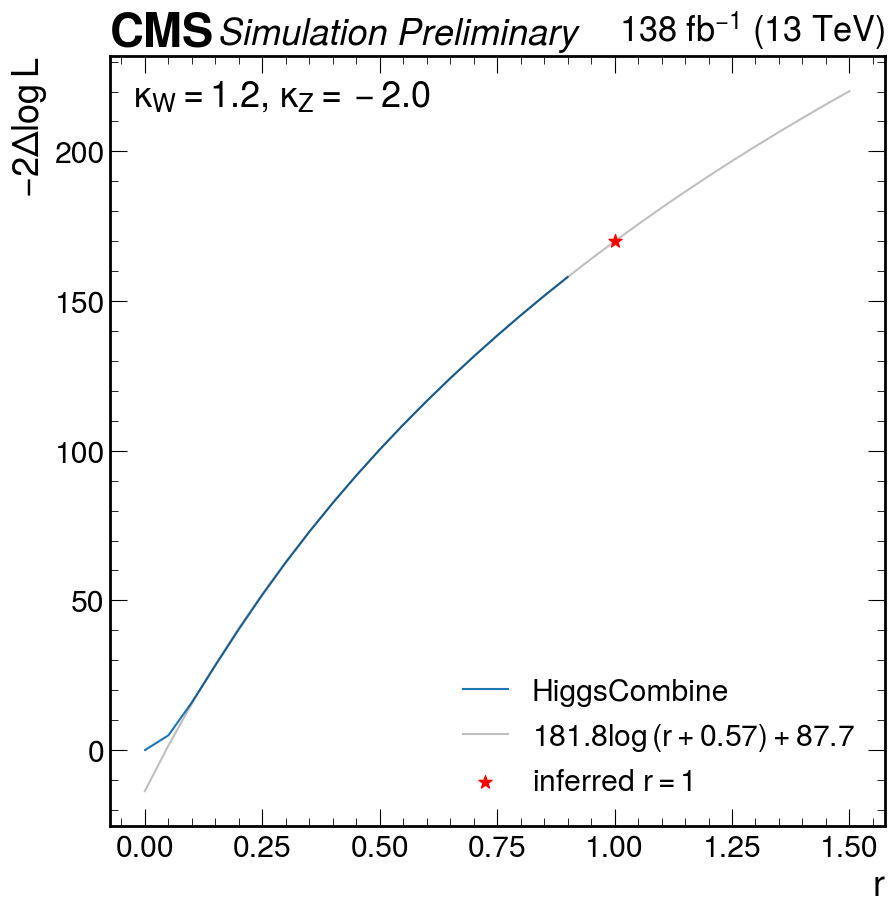

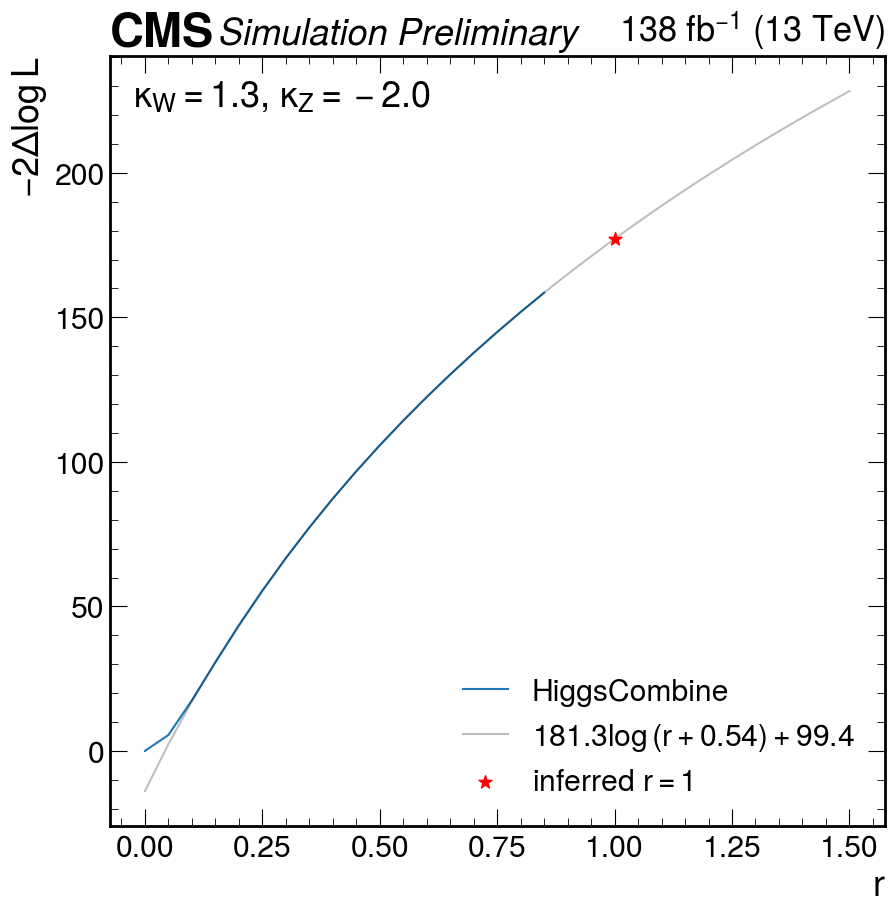

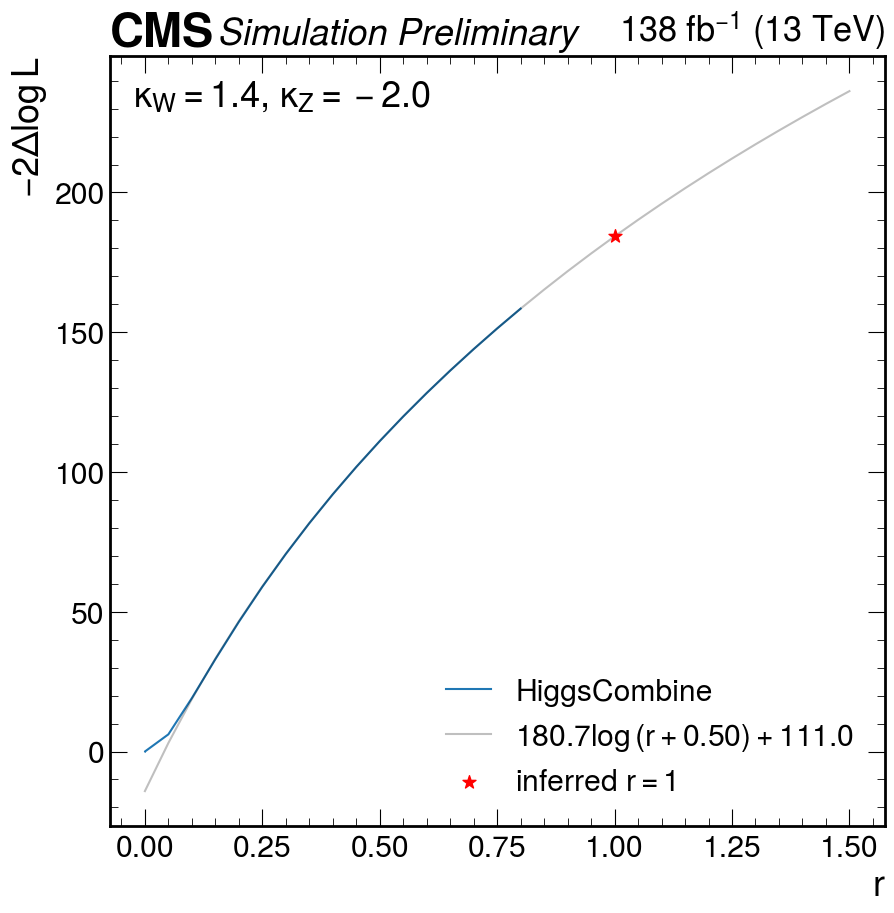

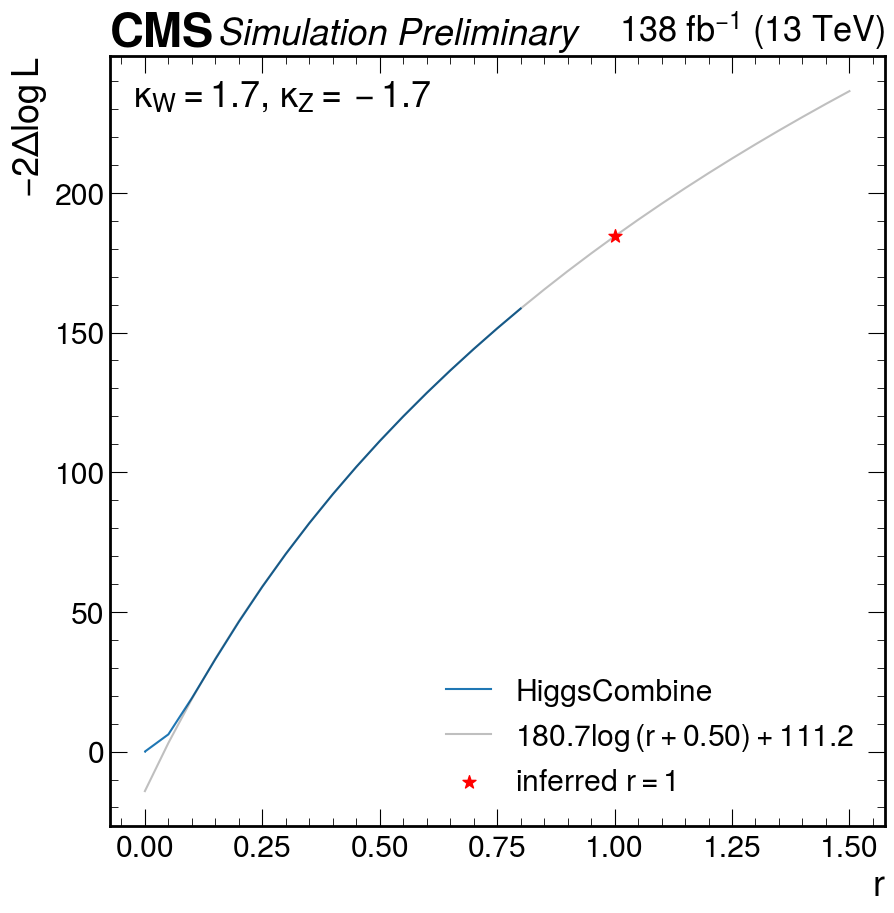

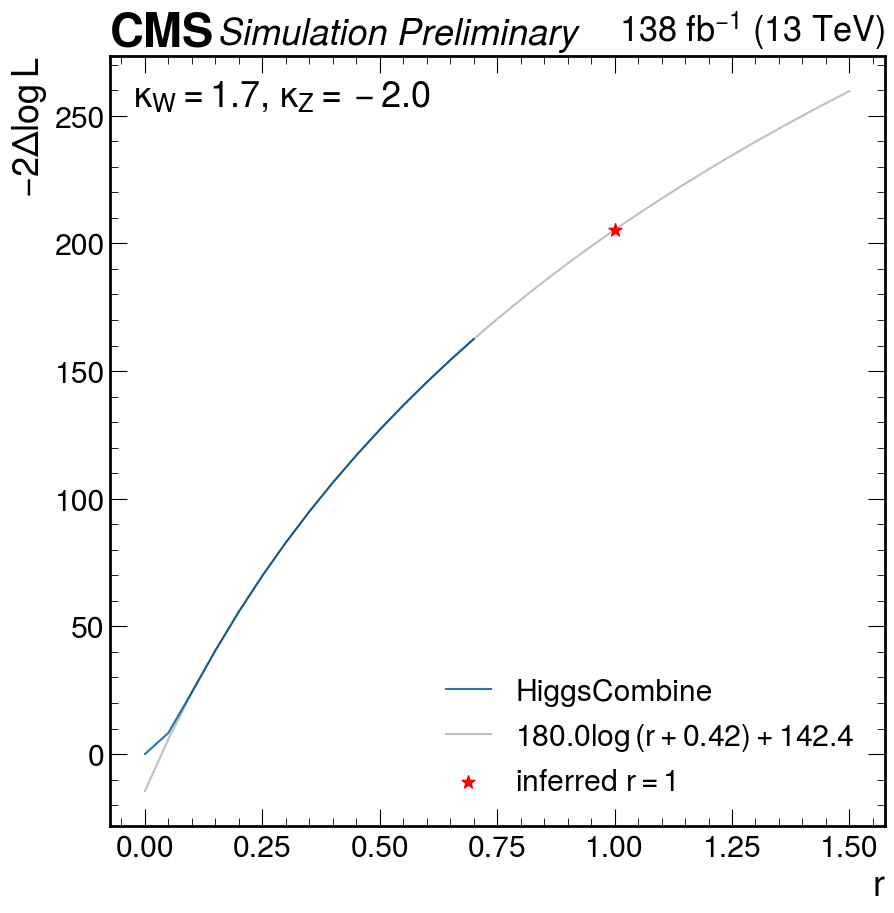

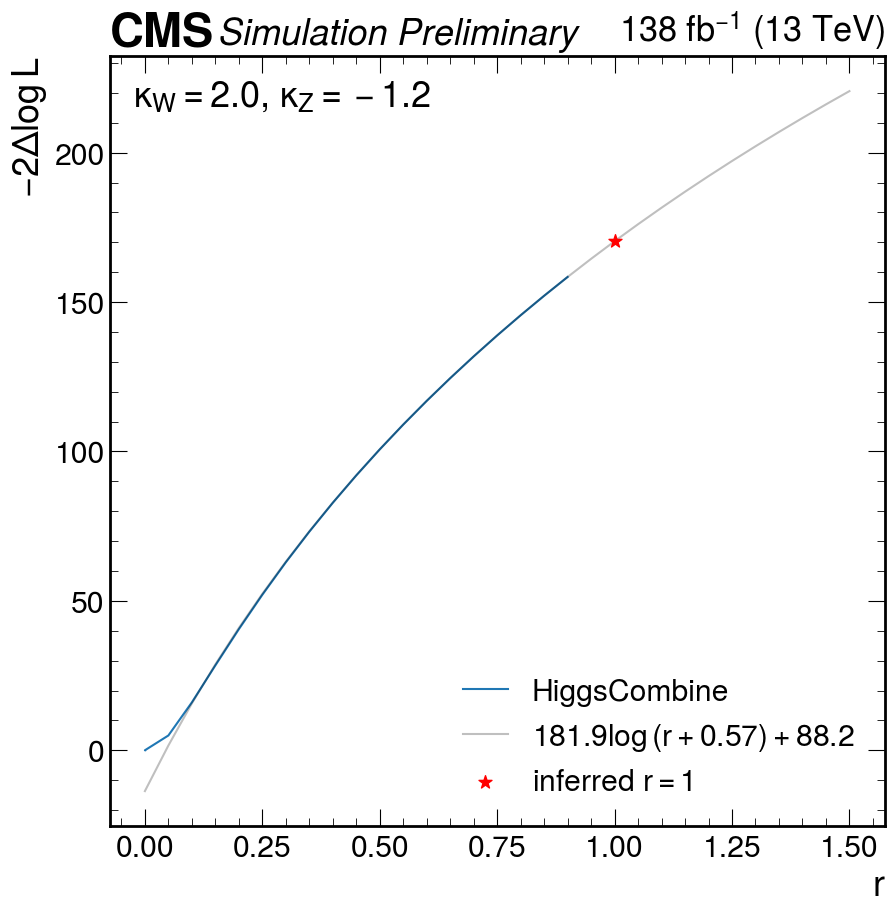

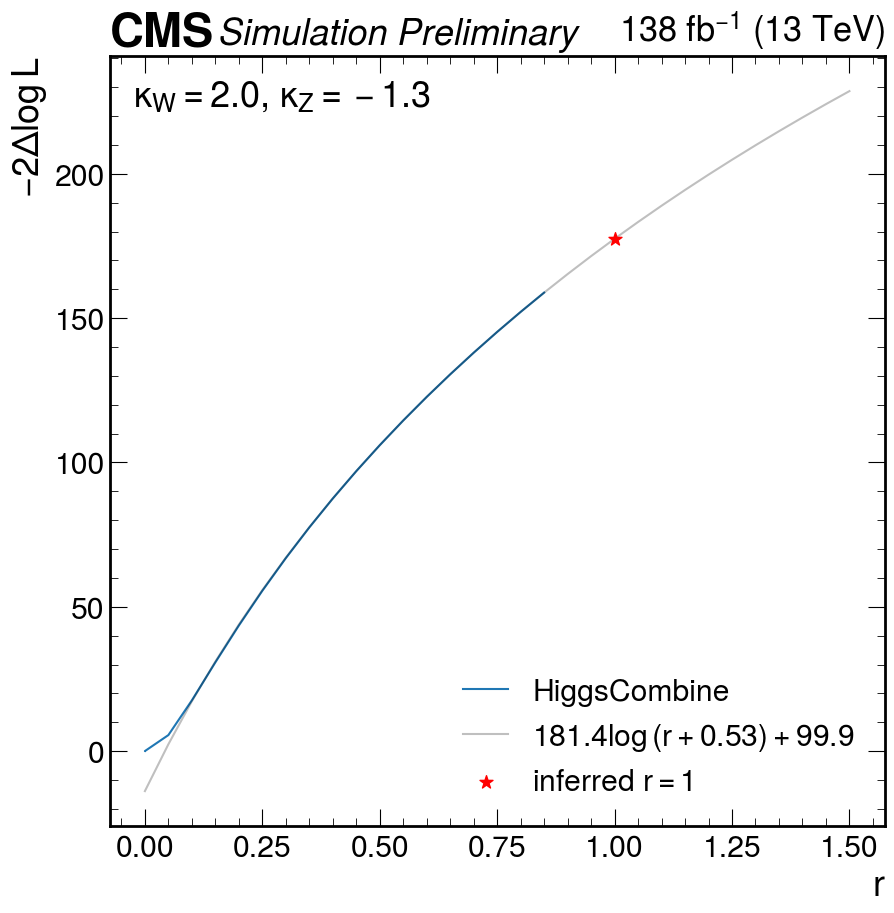

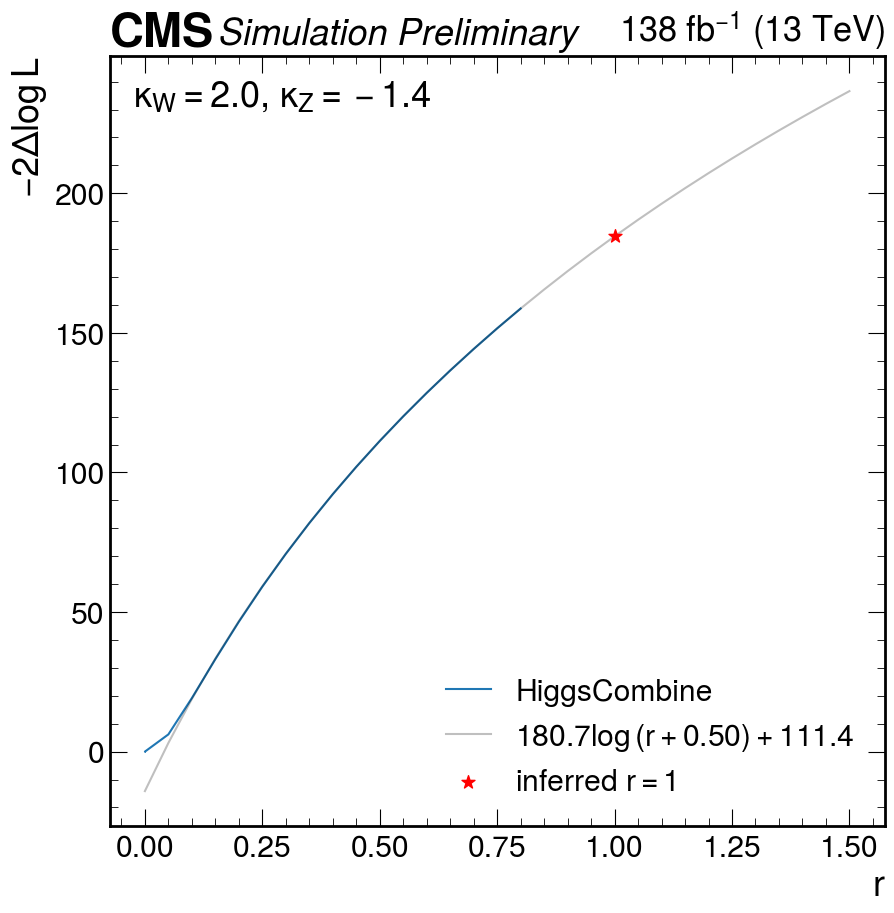

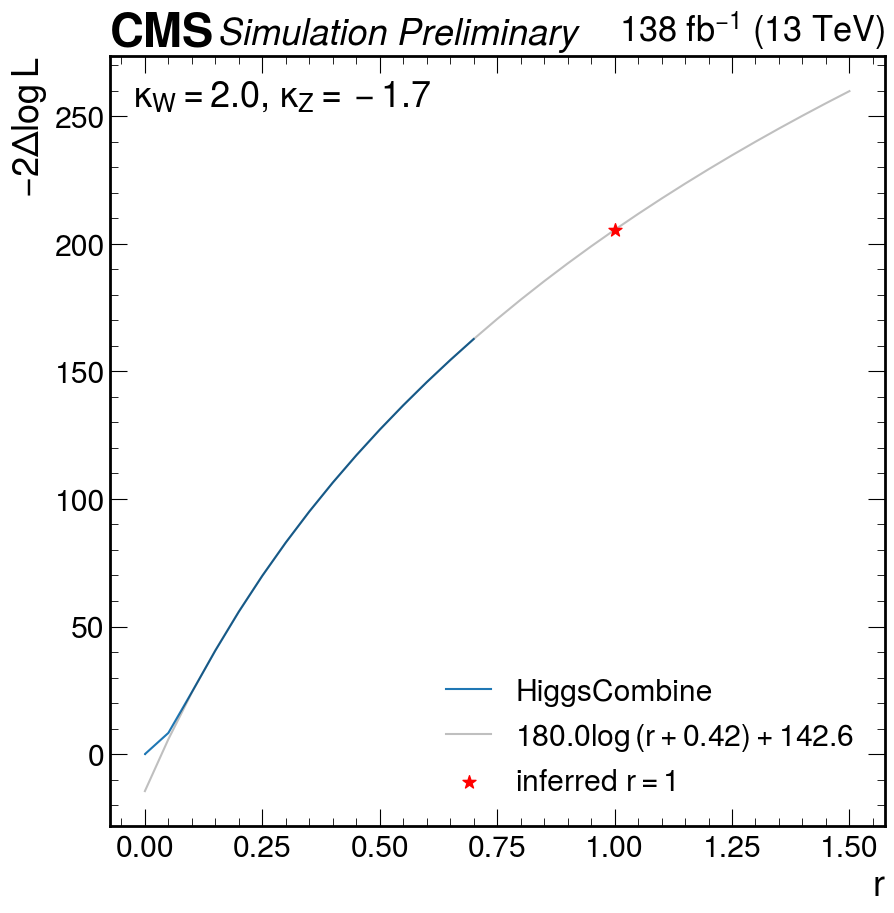

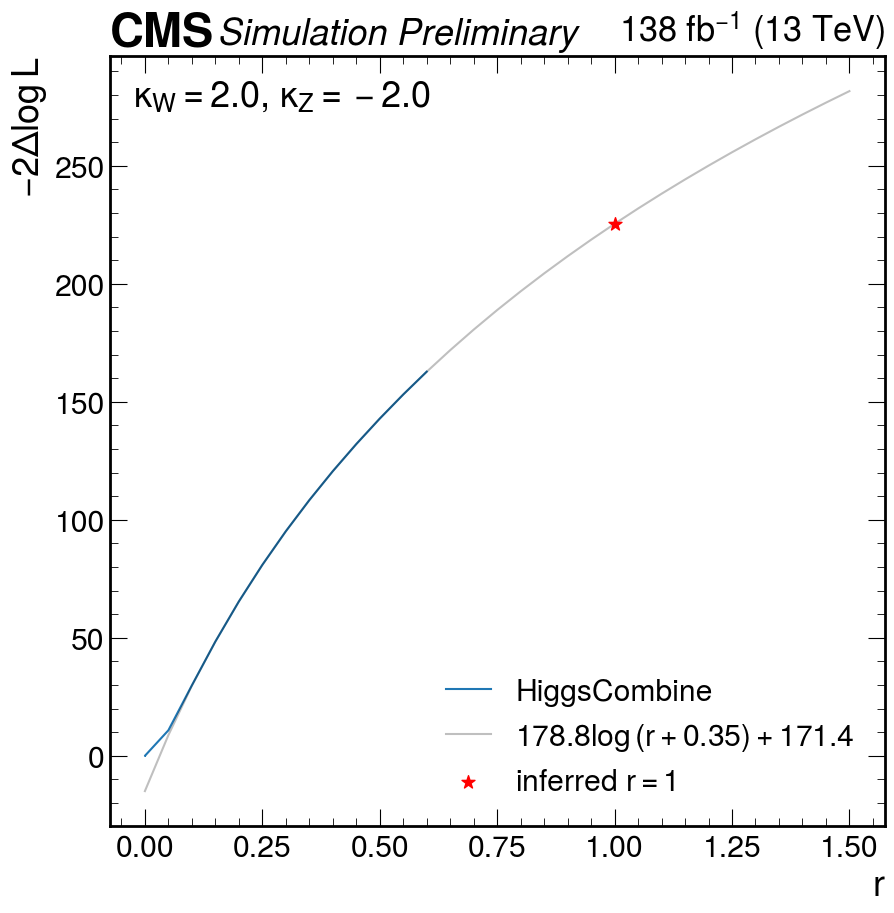

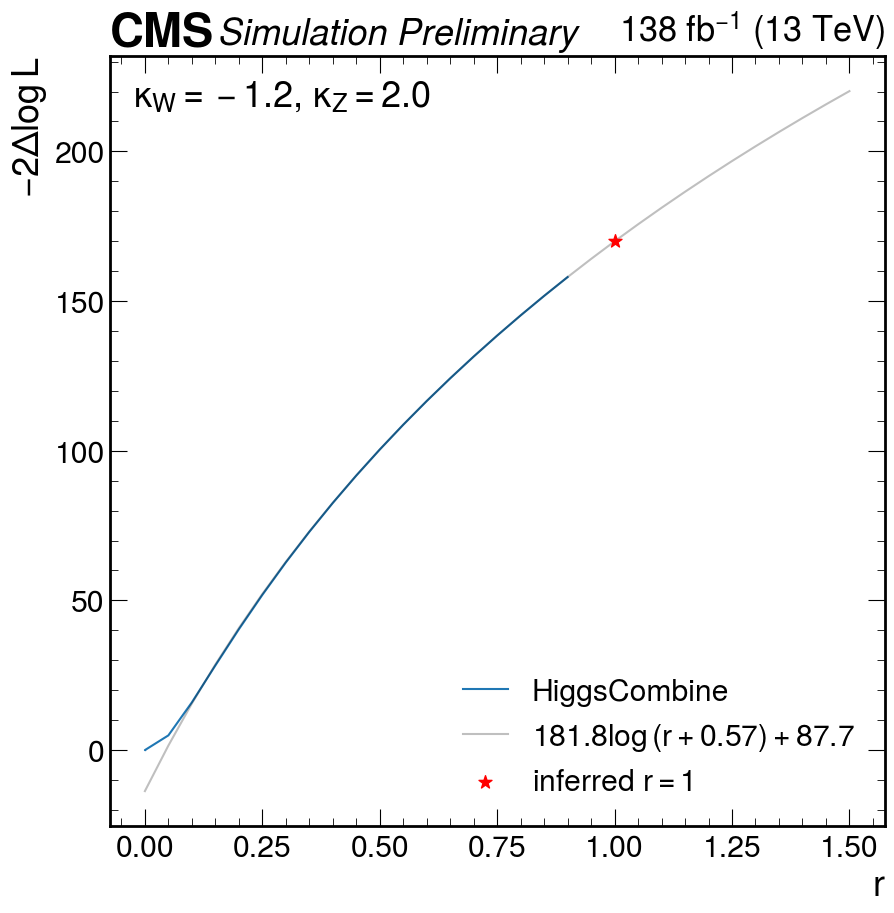

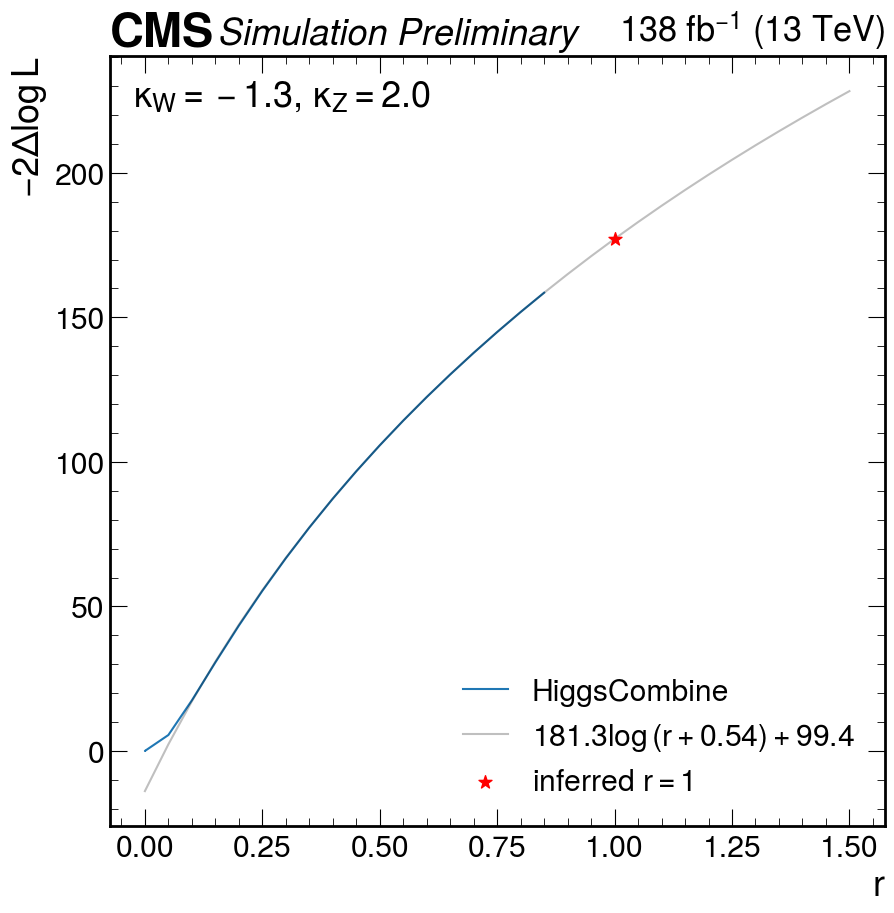

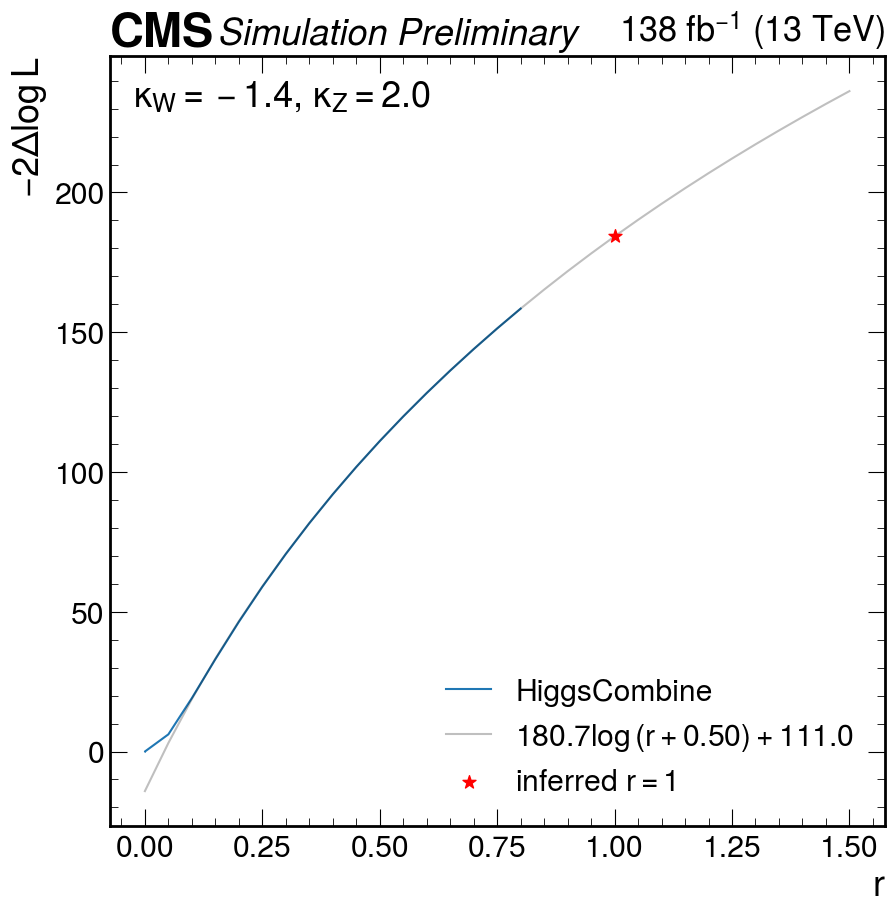

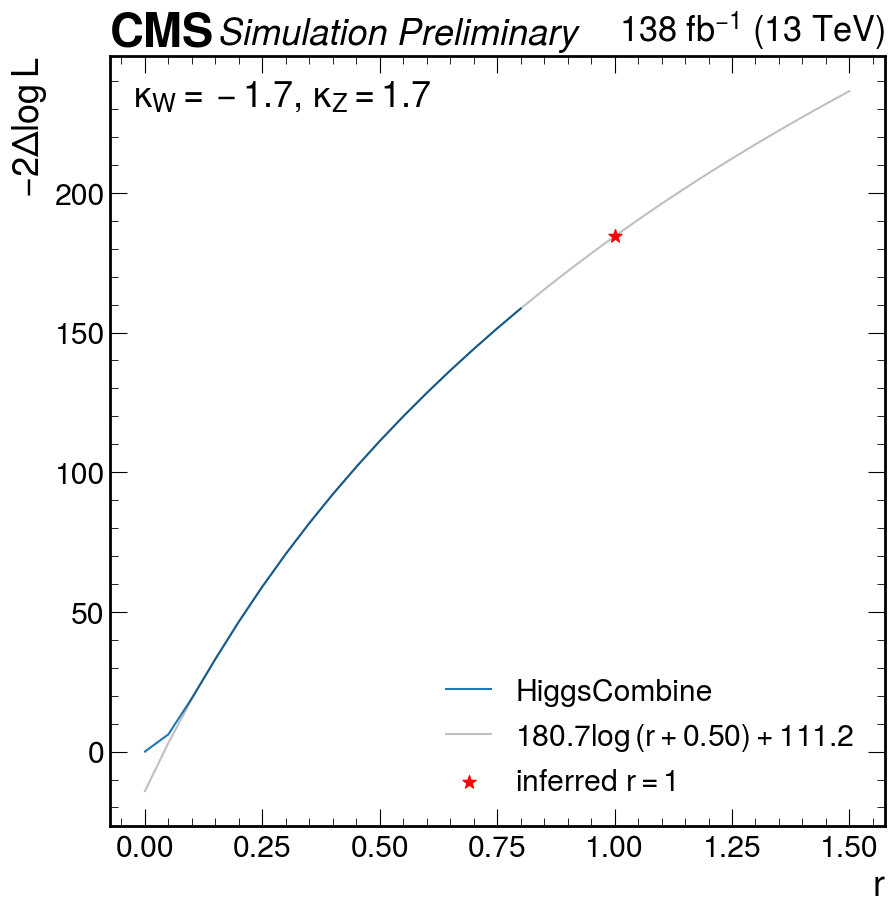

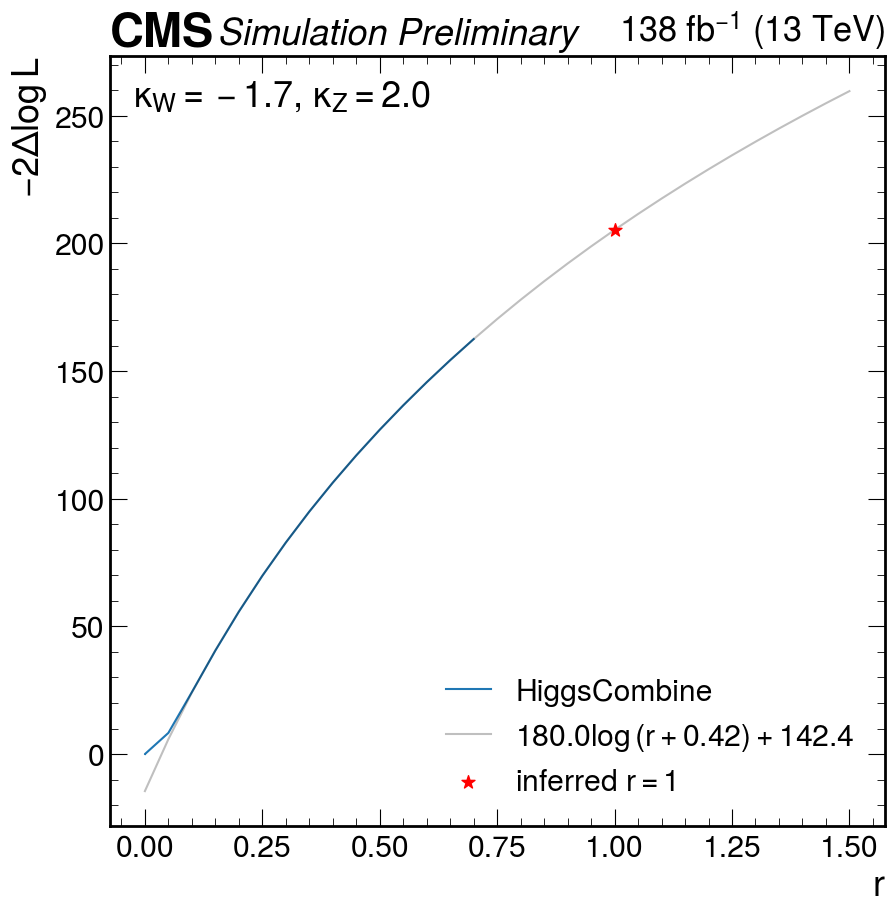

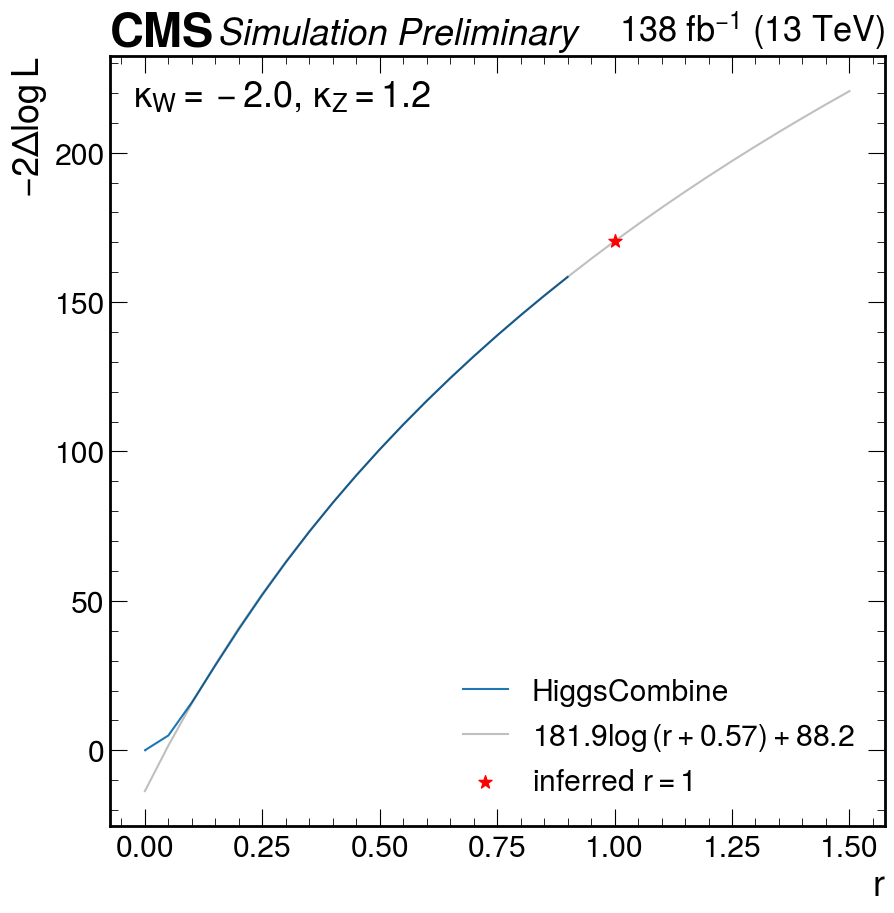

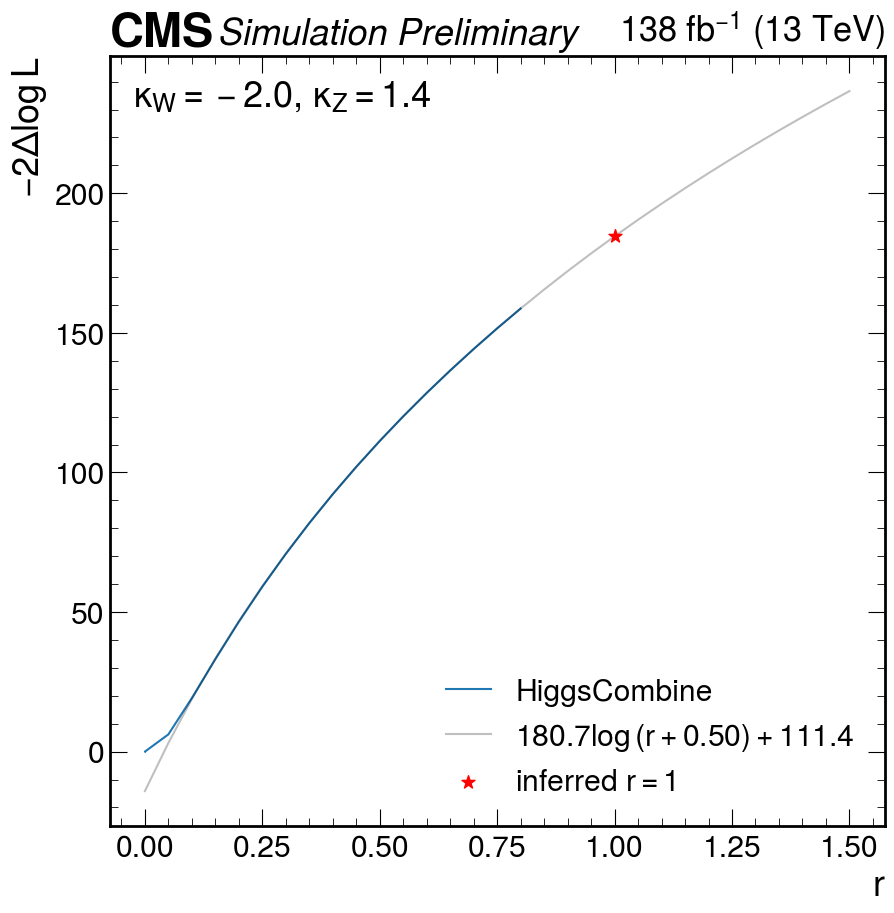

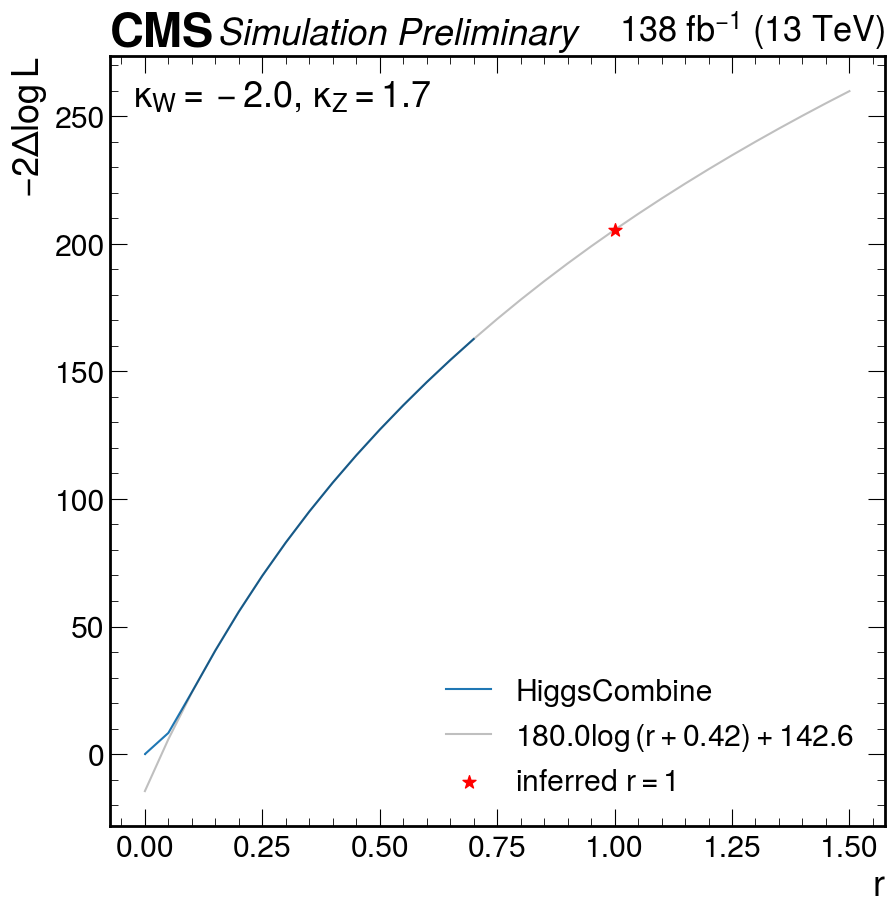

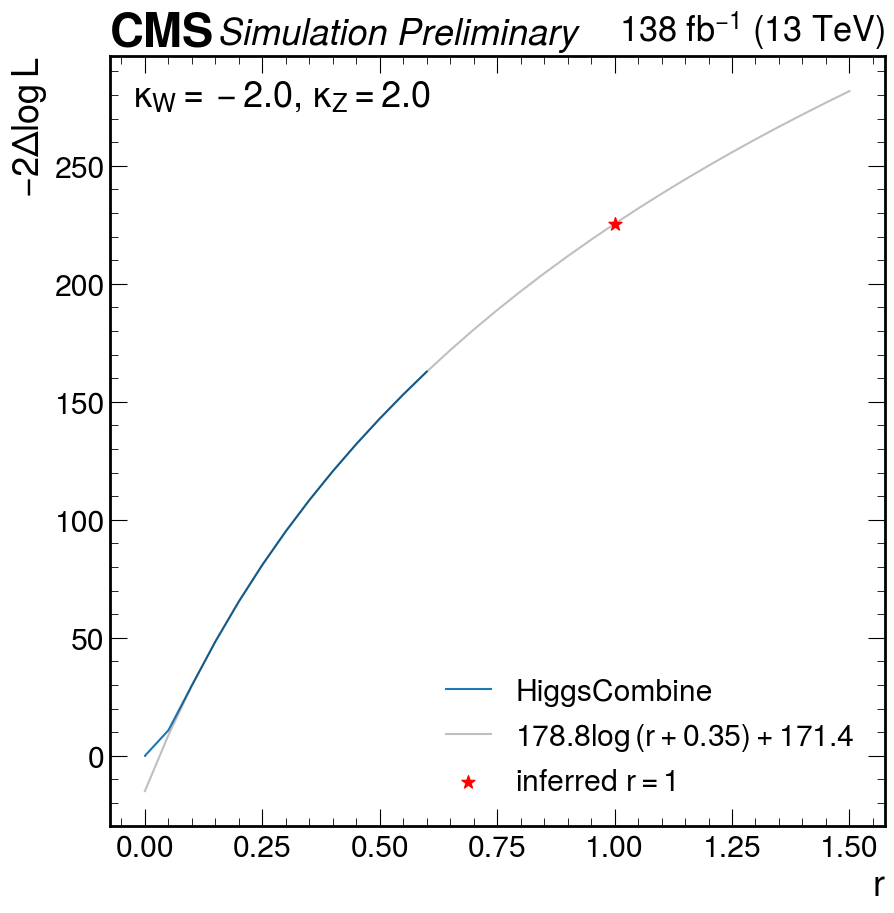

In [2]:
import warnings
warnings.filterwarnings("ignore")

r_eq_1_sigmas = []
kW_points = []
kZ_points = []
kW_spec_points = []
kZ_spec_points = []
for combine_root_file in tqdm(glob.glob("../combine/results/*.root")):
    with uproot.open(combine_root_file) as f:
        points = f.get("limit").arrays(["r", "deltaNLL"], library="np")
        points["deltaNLL"] *= 2
        
    scan_name = combine_root_file.split("/")[-1].replace("m", "-").replace("p", ".").replace(".root", "")
    kW_points.append(float(scan_name.split("_")[2]))
    kZ_points.append(float(scan_name.split("_")[4]))

    r_eq_1_indices = np.where(points["r"] == 1)[0]
    if r_eq_1_indices.size == 0 or np.isnan(points["deltaNLL"][r_eq_1_indices[0]]):
        # Find largest exclusion value (ignore NaNs)
        max_excl_sigma_idx = np.nanargmax(points["deltaNLL"])
        max_excl_sigma = np.sqrt(points["deltaNLL"][max_excl_sigma_idx])
        if max_excl_sigma >= 2 and points["r"][max_excl_sigma_idx] < 1:
            # If the max exclusion is >= 2sigma and the corresponding r-value is less than one, then
            # the r-value of 1 is certainly excluded at some large value

            # Plot original curve
            fig, axes = plt.subplots()
            nans = np.isnan(points["deltaNLL"])
            axes.plot(points["r"][~nans], points["deltaNLL"][~nans], label="HiggsCombine")
            # Fit last 10 points to a log
            curve = lambda x, A, B, C: A*np.log(x + B) + C
            opt_params, _ = curve_fit(curve, points["r"][~nans][-10:], points["deltaNLL"][~nans][-10:])
            # Plot best fit
            A, B, C = opt_params
            axes.plot(
                np.linspace(0, 1.5, 31), 
                [curve(x, *opt_params) for x in np.linspace(0, 1.5, 31)], 
                color="k", alpha=0.25,
                label=(r"$A\log{(r B)} C$".replace("A", f"{A:0.1f}")
                                          .replace("B", f"{B:+0.2f}")
                                          .replace("C", f"{C:+0.1f}"))
            )
            # Plot best fit value at r = 1
            axes.scatter(
                1, curve(1, *opt_params), 
                marker="*", color="r", s=96, zorder=100, 
                label=r"inferred $r = 1$"
            )
            axes.set_xlabel("r");
            axes.set_ylabel(r"$-2\Delta\log{L}$");
            
            # Take best fit value at r = 1 as exclusion sigma
            r_eq_1_sigmas.append(np.sqrt(curve(1, *opt_params)))
            
            # Add kW and kZ label
            axes.text(
                0.03, 0.97,
                (r"$\kappa_W = KW$, $\kappa_Z = KZ$".replace("KW", f"{kW_points[-1]:.1f}")
                                                    .replace("KZ", f"{kZ_points[-1]:.1f}")),
                ha="left", va="top",
                transform = axes.transAxes
            )
            # Add CMS label
            hep.cms.label(
                "Preliminary",
                data=False,
                lumi=138,
                loc=0,
                ax=axes
            );
            axes.legend(loc="lower right");
            
            plt.savefig(
                f"/home/users/jguiang/public_html/vbswh_plots/limits/"
                + combine_root_file.split("/")[-1].replace(".root", ".pdf"),
                bbox_inches="tight"
            )
            
            kW_spec_points.append(kW_points[-1])
            kZ_spec_points.append(kZ_points[-1])
        else:
            # Otherwise, we are in trouble; let's diagnose!
            print(combine_root_file)
            print("Uh oh!")
            print(points["deltaNLL"][np.nanargmax(points["deltaNLL"])])
            print(points["r"])
            print(np.sqrt(points["deltaNLL"]))
            fig, axes = plt.subplots()
            axes.plot(points["r"], points["deltaNLL"])
            break
    else:
        r_eq_1_sigmas.append(np.sqrt(points["deltaNLL"][r_eq_1_indices[0]]))
        
r_eq_1_sigmas = np.clip(np.array(r_eq_1_sigmas), 0, 10000)
kW_points = np.array(kW_points)
kZ_points = np.array(kZ_points)

In [3]:
kW_values = np.unique(kW_points)
kW_widths = kW_values[1:] - kW_values[:-1]
kW_bin_edges = np.union1d(
    kW_values[:-1] + 0.5*kW_widths,
    kW_values[1:]  - 0.5*kW_widths,
)
kW_bin_edges = np.concatenate((
    [kW_values[0] - 0.5*kW_widths[0]],
    kW_bin_edges,
    [kW_values[-1] + 0.5*kW_widths[-1]]
))

kZ_values = np.unique(kZ_points)
kZ_widths = kZ_values[1:] - kZ_values[:-1]
kZ_bin_edges = np.union1d(
    kZ_values[:-1] + 0.5*kZ_widths,
    kZ_values[1:]  - 0.5*kZ_widths
)
kZ_bin_edges = np.concatenate((
    [kZ_values[0] - 0.5*kZ_widths[0]],
    kZ_bin_edges,
    [kZ_values[-1] + 0.5*kZ_widths[-1]]
))

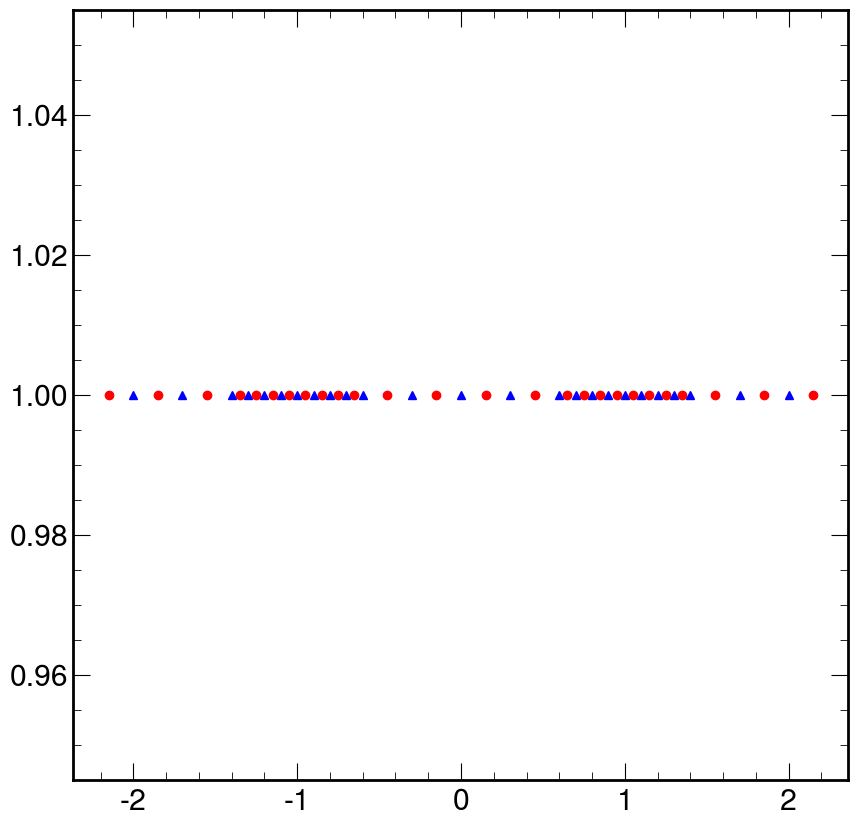

In [4]:
fig, axes = plt.subplots()
axes.plot(
    kW_bin_edges, np.ones(kW_bin_edges.shape), "ro"
)
axes.plot(
    kW_values, np.ones(kW_values.shape), "b^"
)

In [5]:
def zero_out_sigmas(sigmas, kW_points, kZ_points, *kWkZ_to_zero, zero_val=0):
    filtered_sigmas = sigmas.copy()
    for kW, kZ in kWkZ_to_zero:
        filtered_sigmas[np.where((kW_points == kW) & (kZ_points == kZ))] = zero_val
        
    return np.array(filtered_sigmas)

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as clr

cmap = clr.LinearSegmentedColormap.from_list("trident", ["#182B49","#00629B", "#C69214", "#FFCD00"], N=256)

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    return fig.colorbar(mappable, cax=cax)

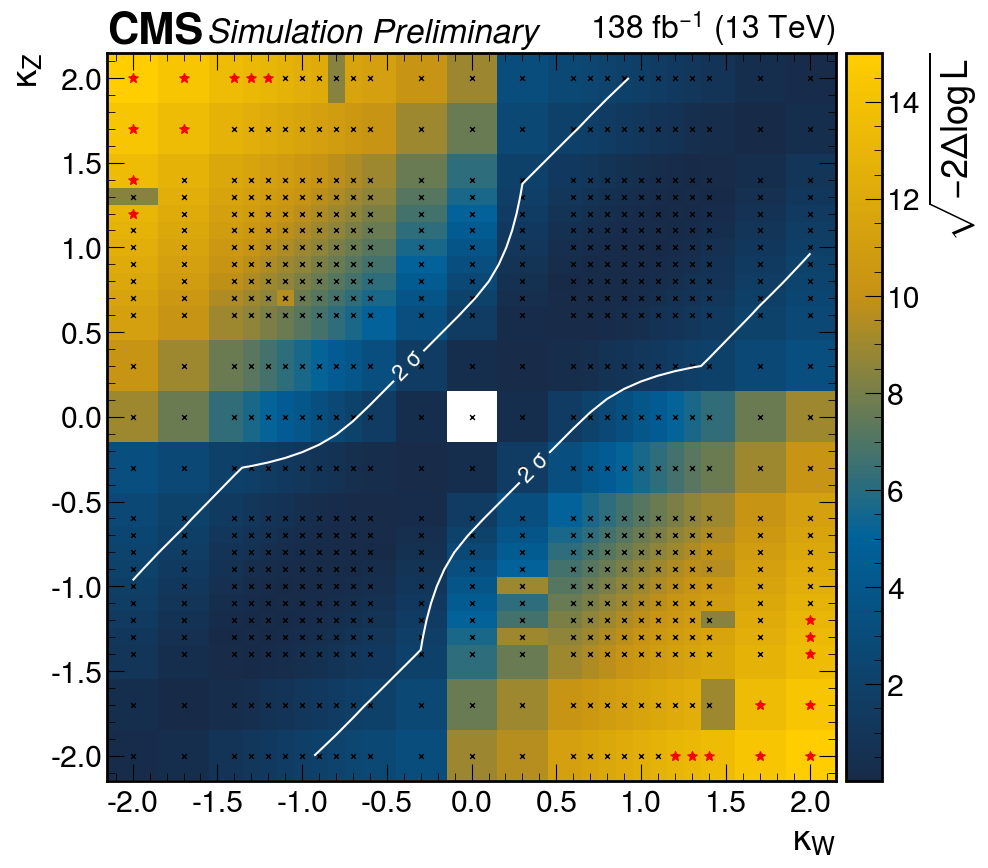

In [7]:
hist2d = yahist.Hist2D(
    (kW_points, kZ_points),
    bins=[kW_bin_edges, kZ_bin_edges],
    weights=r_eq_1_sigmas
)

# Plot 2D hist
fig, axes = plt.subplots()
mpl_objs = hist2d.plot(ax=axes, colorbar=False, cmap=cmap);
# mpl_objs = hist2d.plot(
#     ax=axes, colorbar=False, counts=True, counts_formatter="{:.1f}".format, counts_fontsize=6, cmap=cmap
# );
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");
axes.set_aspect("equal");

# Plot (kW, kZ) points where sigma is taken directly from log-likelihood plot
axes.scatter(kW_points, kZ_points, marker="x", color="k", linewidths=1, s=12)
# Plot (kW, kZ) points where sigma is inferred from log-likelihood plot
axes.scatter(kW_spec_points, kZ_spec_points, marker="*", color="r", s=48)

# Plot colorbar
cbar = colorbar(mpl_objs[0]);
cbar.set_label(r"$\sqrt{-2\Delta\logL}$");

# Plot contour(s)
contours = axes.contour(
    np.unique(kW_points), np.unique(kZ_points), 
    hist2d.counts,
    [2],
    colors=["white"]
)

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
    lumi=138,
    loc=0,
    ax=axes,
    fontsize=24
);

axes.clabel(contours, contours.levels, inline=True, fmt=lambda x: f"{x:g}"+r" $\sigma$", fontsize=16);

axes.set_xticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]);
axes.set_yticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]);

plt.savefig("/home/users/jguiang/public_html/vbswh_plots/limits/raw_exclusion_2D_alt.pdf", bbox_inches="tight");

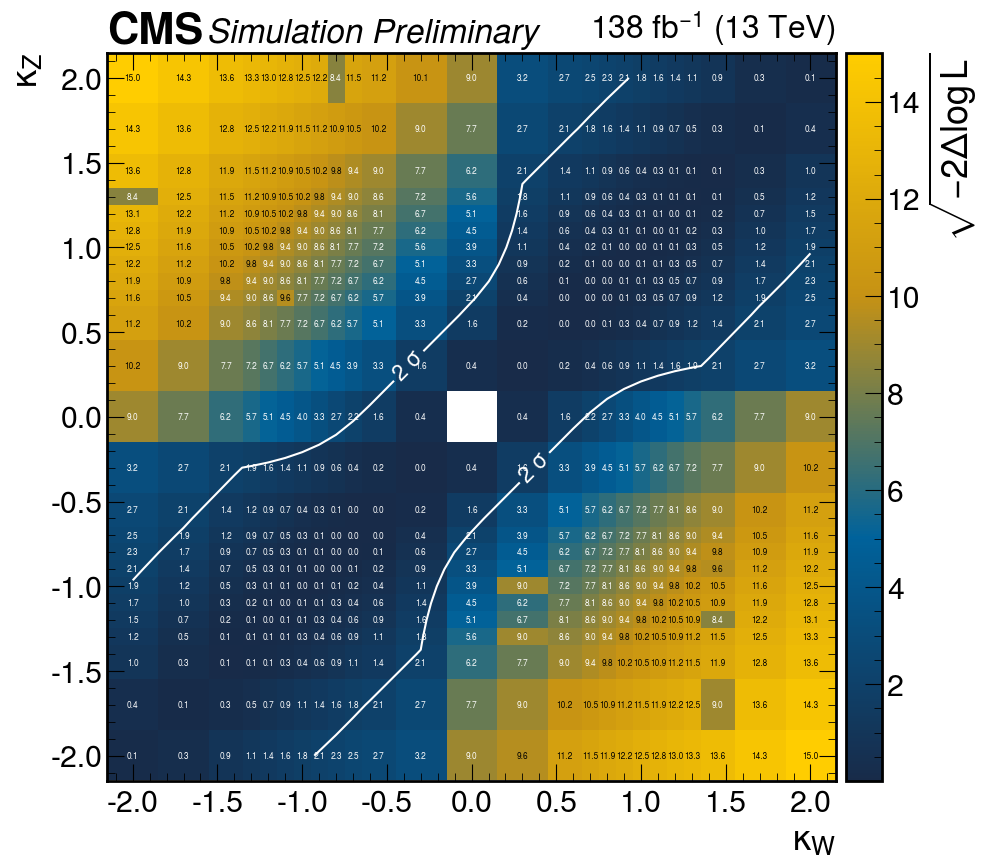

In [8]:
hist2d = yahist.Hist2D(
    (kW_points, kZ_points),
    bins=[kW_bin_edges, kZ_bin_edges],
    weights=r_eq_1_sigmas
)

# Plot 2D hist
fig, axes = plt.subplots()
mpl_objs = hist2d.plot(
    ax=axes, colorbar=False, counts=True, counts_formatter="{:.1f}".format, counts_fontsize=6, cmap=cmap
);
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");
axes.set_aspect("equal");

# Plot colorbar
cbar = colorbar(mpl_objs[0]);
cbar.set_label(r"$\sqrt{-2\Delta\logL}$");


# Plot contour(s)
contours = axes.contour(
    np.unique(kW_points), np.unique(kZ_points), 
    hist2d.counts,
    [2],
    colors=["white"]
)

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
    lumi=138,
    loc=0,
    ax=axes,
    fontsize=24
);

axes.clabel(contours, contours.levels, inline=True, fmt=lambda x: f"{x:g}"+r" $\sigma$", fontsize=16);

axes.set_xticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]);
axes.set_yticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]);

plt.savefig("/home/users/jguiang/public_html/vbswh_plots/limits/raw_exclusion_2D.pdf", bbox_inches="tight");

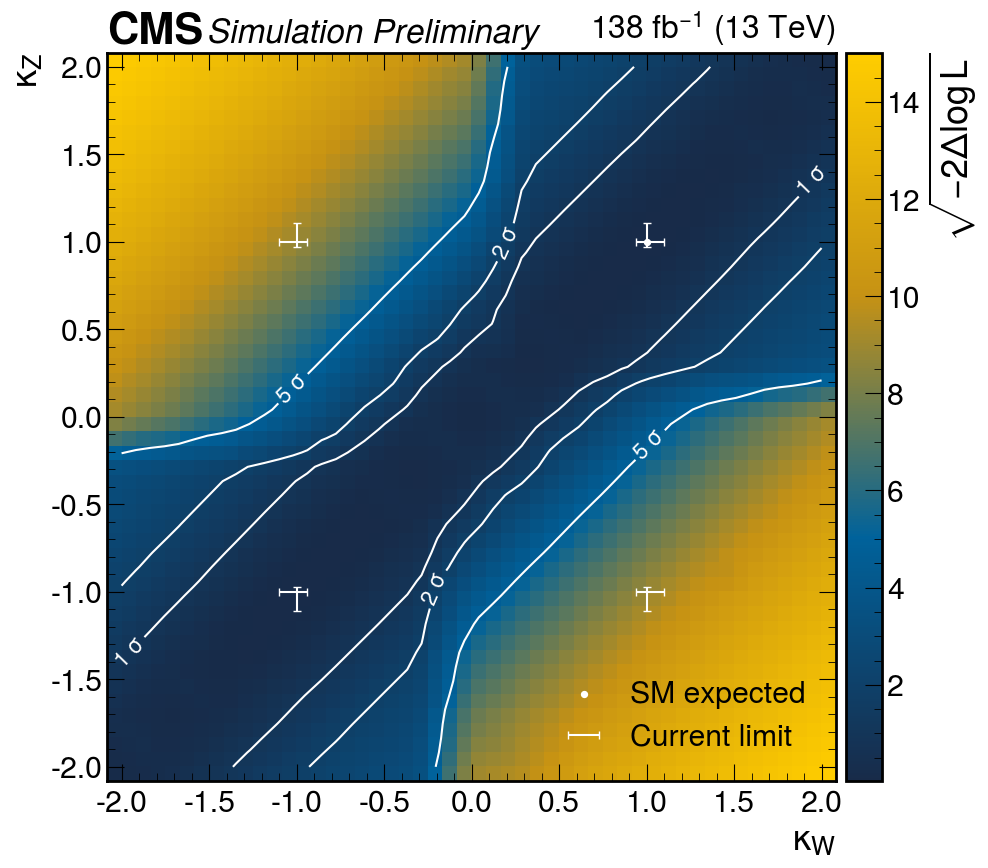

In [9]:
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator

kmin = -2
kmax = 2
kpnts = 50

filtered_sigmas = zero_out_sigmas(
    r_eq_1_sigmas, kW_points, kZ_points,
    (1.4, -1.7), (1.4, -1.2), (-0.8, 2.0), 
    (-2.0, 1.3), (0.3, -1.3), (0.3, -1.0), 
    (-1.1, 0.7),
    zero_val = -999
)

grid_x, grid_y = np.mgrid[-2:2:kpnts*1j, -2:2:kpnts*1j]
test = griddata(
    (kW_points[filtered_sigmas != -999], kZ_points[filtered_sigmas != -999]), 
    filtered_sigmas[filtered_sigmas != -999], 
    (grid_x, grid_y), 
    method="linear",
    rescale=True
)

kW_fine = np.tile(
    np.linspace(kmin, kmax, kpnts), (kpnts, 1)
).T.flatten()
kZ_fine = np.tile(
    np.linspace(kmin, kmax, kpnts), (kpnts, 1)
).flatten()

kW_bin_edges_fine = np.linspace(-2 - (kmax - kmin)/(kpnts - 1), 2 + (kmax - kmin)/(kpnts - 1), kpnts+1)
kZ_bin_edges_fine = np.linspace(-2 - (kmax - kmin)/(kpnts - 1), 2 + (kmax - kmin)/(kpnts - 1), kpnts+1)

hist2d = yahist.Hist2D(
    (grid_x.flatten(), grid_y.flatten()),
    bins=[kW_bin_edges_fine, kZ_bin_edges_fine],
    weights=test.flatten()
)

# Plot 2D hist
fig, axes = plt.subplots()
mpl_objs = hist2d.plot(ax=axes, colorbar=False, cmap=cmap);
# mpl_objs = hist2d.plot(ax=axes, colorbar=False, counts=True, counts_formatter="{:.1f}".format, counts_fontsize=6);
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");
axes.set_aspect("equal");

# Plot colorbar
cbar = colorbar(mpl_objs[0]);
cbar.set_label(r"$\sqrt{-2\Delta\logL}$");

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
    lumi=138,
    loc=0,
    ax=axes,
    fontsize=24
);

# Plot contour(s)
contours = axes.contour(
    np.unique(grid_x.flatten()), np.unique(grid_y.flatten()), 
    hist2d.counts,
    [1, 2, 5],
    colors=["white"]
)

axes.errorbar(1.0, 1.04, yerr=0.07, capsize=3, color="white", ls="none");
axes.errorbar(1.02, 1.0, xerr=0.08, capsize=3, color="white", ls="none", label="Current limit");
axes.scatter(1.0, 1.0, zorder=100, s=18, color="white", label="SM expected");

axes.errorbar(-1.0, 1.04, yerr=0.07, capsize=3, color="white", ls="none");
axes.errorbar(-1.02, 1.0, xerr=0.08, capsize=3, color="white", ls="none");


axes.errorbar(1.0, -1.04, yerr=0.07, capsize=3, color="white", ls="none");
axes.errorbar(1.02, -1.0, xerr=0.08, capsize=3, color="white", ls="none");

axes.errorbar(-1.0, -1.04, yerr=0.07, capsize=3, color="white", ls="none");
axes.errorbar(-1.02, -1.0, xerr=0.08, capsize=3, color="white", ls="none");

axes.clabel(contours, contours.levels, inline=True, fmt=lambda x: f"{x:g}"+r" $\sigma$", fontsize=16);
axes.legend(loc="lower right");

axes.set_xticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]);
axes.set_yticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]);

plt.savefig("/home/users/jguiang/public_html/vbswh_plots/limits/exclusion_2D.pdf", bbox_inches="tight");

In [10]:
def curve_neg(data, A, B, C):
    x = data[:,0]
    y = data[:,1]
#     return A*(x - y)**2 + B
#     return A*(x - y)**2 + B*(x + y)**2 + C
#     return A*(x - y)**4 + B*(x + y)**4 + C
#     return np.abs(A*(x - y)**2 + B*(x + y)**2 + C)
    return np.sqrt(np.abs(A*(x - y)**2 + B*(x + y)**2 + C))
#     return A*x**2 + B*y**2 + C

def curve_pos(data, A, B):
    x = data[:,0]
    y = data[:,1]
#     return A*(x - y)**2 + B
#     return A*np.sqrt(np.abs(x - y))
    return A*(x - y)**2 + B
#     return A*(x - y)**2 + B*(x + y)**2 + C
#     return A*(x - y)**4 + B*(x + y)**4 + C
#     return np.abs(A*(x - y)**2 + B*(x + y)**2 + C)
#     return np.sqrt(np.abs(A*(x - y)**2 + B*(x + y)**2 + C))
#     return A*x**2 + B*y**2 + C

all_pos = (kW_points*kZ_points > 0)
all_neg = (kW_points*kZ_points <= 0)

opt_params_neg, _ = curve_fit(curve_neg, np.array(list(zip(kW_points[all_neg], kZ_points[all_neg]))), r_eq_1_sigmas[all_neg])
opt_params_pos, _ = curve_fit(curve_pos, np.array(list(zip(kW_points[all_pos], kZ_points[all_pos]))), r_eq_1_sigmas[all_pos])

In [11]:
opt_params_neg

array([18.2050881 ,  1.1060208 , -0.75695038])

In [12]:
opt_params_pos

array([1.37467532, 0.23693343])

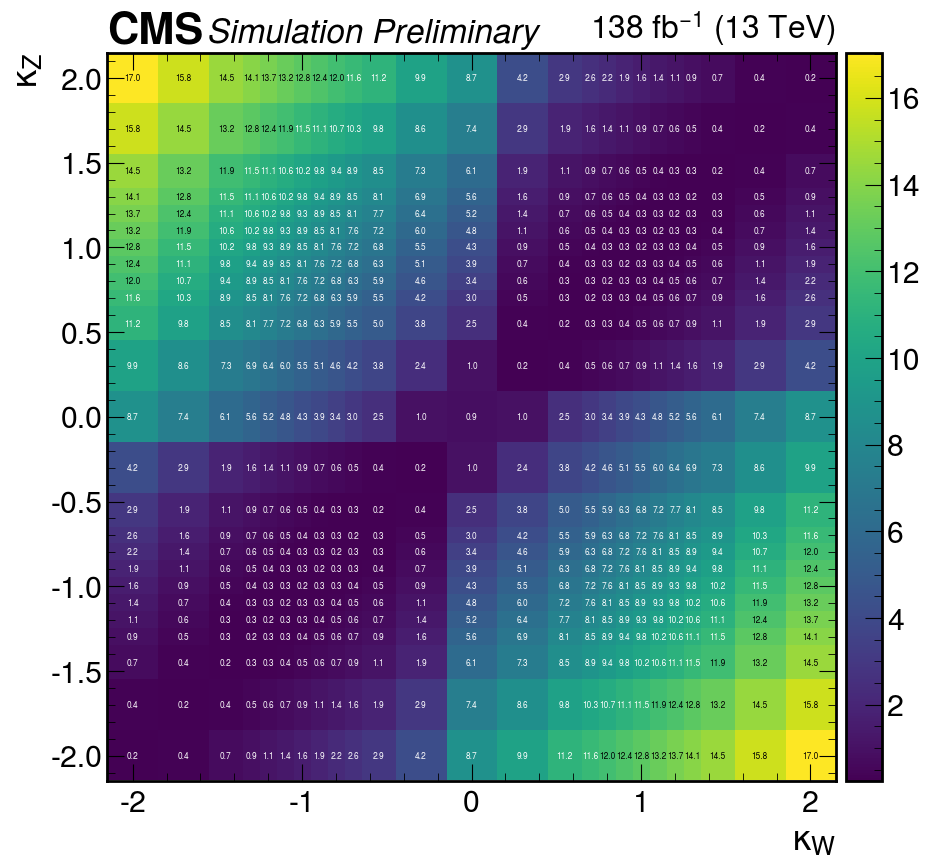

In [13]:
hist2d = yahist.Hist2D(
    (kW_points[all_neg], kZ_points[all_neg]),
    bins=[kW_bin_edges, kZ_bin_edges],
    weights=(
        curve_neg(np.array(list(zip(kW_points[all_neg], kZ_points[all_neg]))), *opt_params_neg)
    )
)
hist2d += yahist.Hist2D(
    (kW_points[all_pos], kZ_points[all_pos]),
    bins=[kW_bin_edges, kZ_bin_edges],
    weights=(
        curve_pos(np.array(list(zip(kW_points[all_pos], kZ_points[all_pos]))), *opt_params_pos)
    )
)

# Plot 2D hist
fig, axes = plt.subplots()
mpl_objs = hist2d.plot(ax=axes, colorbar=False, counts=True, counts_formatter="{:.1f}".format, counts_fontsize=6);
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");
axes.set_aspect("equal");

# Plot colorbar
colorbar(mpl_objs[0]);

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
    lumi=138,
    loc=0,
    ax=axes,
    fontsize=24
);

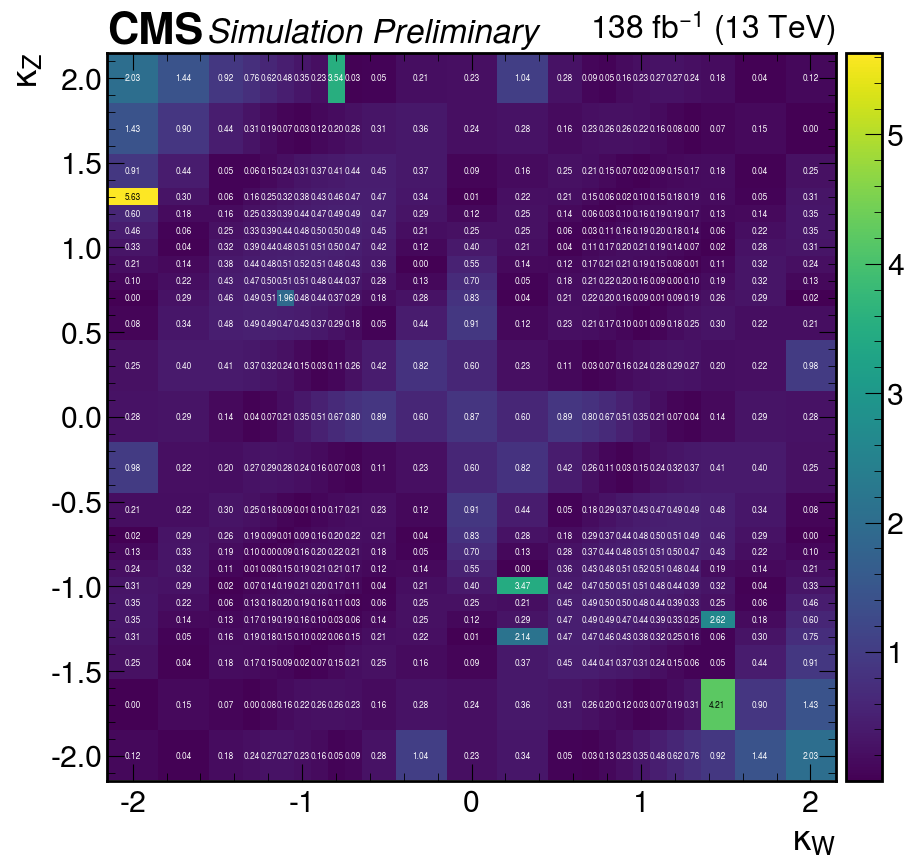

In [14]:
hist2d = yahist.Hist2D(
    (kW_points[all_neg], kZ_points[all_neg]),
    bins=[kW_bin_edges, kZ_bin_edges],
    weights=np.abs(
        curve_neg(np.array(list(zip(kW_points[all_neg], kZ_points[all_neg]))), *opt_params_neg)
        - r_eq_1_sigmas[all_neg]
    )
)
hist2d += yahist.Hist2D(
    (kW_points[all_pos], kZ_points[all_pos]),
    bins=[kW_bin_edges, kZ_bin_edges],
    weights=np.abs(
        curve_pos(np.array(list(zip(kW_points[all_pos], kZ_points[all_pos]))), *opt_params_pos)
        - r_eq_1_sigmas[all_pos]
    )
)

# Plot 2D hist
fig, axes = plt.subplots()
mpl_objs = hist2d.plot(ax=axes, colorbar=False, counts=True, counts_formatter="{:.2f}".format, counts_fontsize=6);
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");
axes.set_aspect("equal");

# Plot colorbar
colorbar(mpl_objs[0]);

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
    lumi=138,
    loc=0,
    ax=axes,
    fontsize=24
);

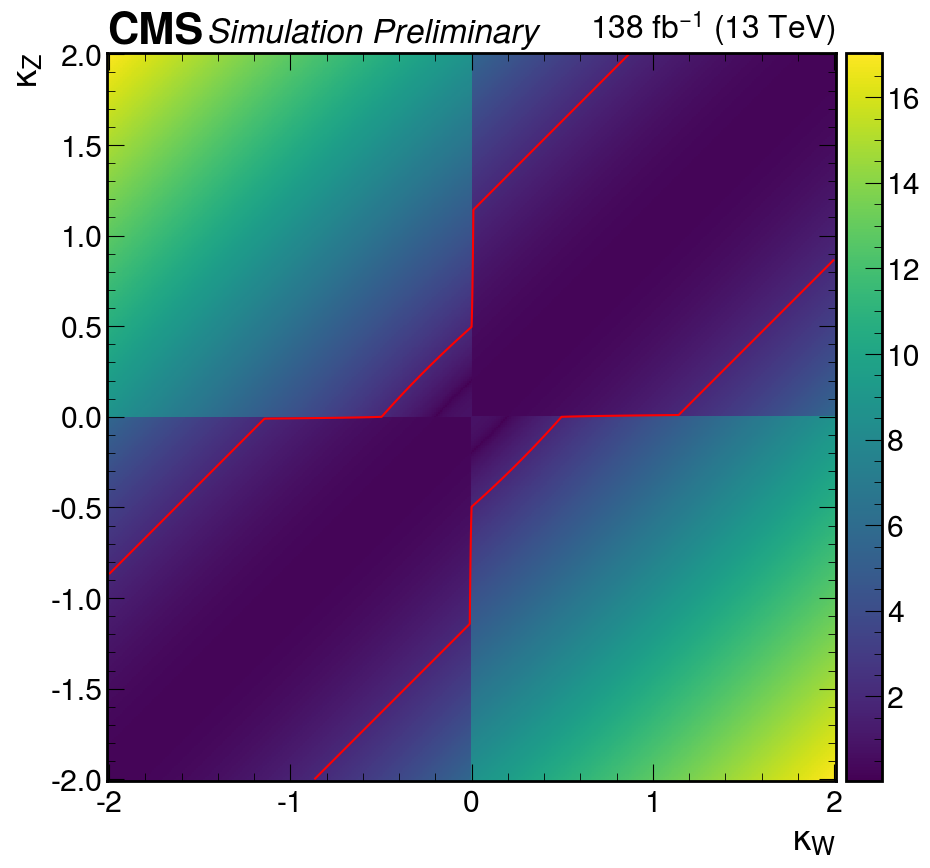

In [15]:
kmin = -2
kmax = 2
kpnts = 401

kW_fine = np.tile(
    np.linspace(kmin, kmax, kpnts), (kpnts, 1)
).T.flatten()
kZ_fine = np.tile(
    np.linspace(kmin, kmax, kpnts), (kpnts, 1)
).flatten()

kW_bin_edges_fine = np.linspace(-2 - (kmax - kmin)/(kpnts - 1), 2 + (kmax - kmin)/(kpnts - 1), kpnts+1)
kZ_bin_edges_fine = np.linspace(-2 - (kmax - kmin)/(kpnts - 1), 2 + (kmax - kmin)/(kpnts - 1), kpnts+1)

all_pos_fine = (kW_fine*kZ_fine > 0)
all_neg_fine = (kW_fine*kZ_fine <= 0)

hist2d = yahist.Hist2D(
    (kW_fine[all_neg_fine], kZ_fine[all_neg_fine]),
    bins=[kW_bin_edges_fine, kZ_bin_edges_fine],
    weights=(
        curve_neg(np.array(list(zip(kW_fine[all_neg_fine], kZ_fine[all_neg_fine]))), *opt_params_neg)
    )
)
hist2d += yahist.Hist2D(
    (kW_fine[all_pos_fine], kZ_fine[all_pos_fine]),
    bins=[kW_bin_edges_fine, kZ_bin_edges_fine],
    weights=(
        curve_pos(np.array(list(zip(kW_fine[all_pos_fine], kZ_fine[all_pos_fine]))), *opt_params_pos)
    )
)

# Plot 2D hist
fig, axes = plt.subplots()
mpl_objs = hist2d.plot(ax=axes, colorbar=False);
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");
axes.set_aspect("equal");

# Plot colorbar
colorbar(mpl_objs[0]);

# Plot contour(s)
axes.contour(
    np.unique(kW_fine), np.unique(kZ_fine), 
    hist2d.counts,
    [2],
    colors=["r"]
)

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
    lumi=138,
    loc=0,
    ax=axes,
    fontsize=24
);

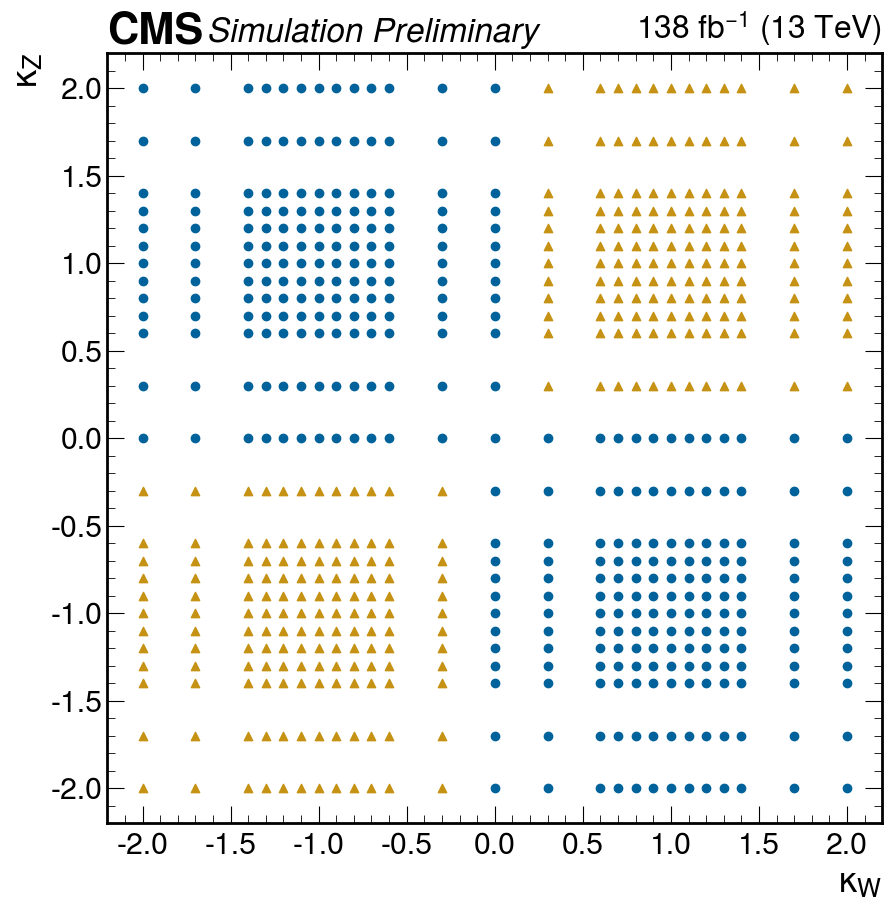

In [16]:
fig, axes = plt.subplots()
axes.scatter(
    kW_points[all_neg], kZ_points[all_neg], marker="o", color="#00629B"
)
axes.scatter(
    kW_points[all_pos], kZ_points[all_pos], marker="^", color="#C69214"
)

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
    lumi=138,
    loc=0,
    ax=axes,
    fontsize=24
);

axes.set_xticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]);
axes.set_yticks([-2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0]);
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");

plt.savefig("/home/users/jguiang/public_html/vbswh_plots/reweighting/scanned_kWkZ.pdf", bbox_inches="tight");